# Exposure Time Calculator 

Below is the code for version 1.5 of the exposure time calculator designed for POET. Current iteration is a working document and will be updated further as work progresses on POET. any inquiries about the workings of the ETC, or for bugs please contact me at nick.swidinsky@uleth.ca.

In [1]:
%matplotlib notebook
from ipywidgets import *
import numpy as np
import pandas as pd
from scipy import integrate
import matplotlib.pyplot as plt
import statistics
import os
from astropy.io import fits #To read in FITS files and tables
import matplotlib



c = 2.998e8 #speed of light (m/s)
h = 6.626e-34 #Planck m^2 kg/s
Pi= np.pi*1.0 #define Pi
Rsun=695700000.0  # Radius of Sun (m)
zero_point = 25.6884
tput = 0.18 
aperture = 0.15
aperture2 = 2.4
gain = 6.1 #Photons needed for a single electron event 

def changeunits(flux):
    """
    Changes the units of flux from ergs/s/cm^2/nm to watts/m^2/nm. 
    Additional scale factor is used to match GAIA magnitude values.
    """
    try:
        fluxScaled = flux * 1e-7/(0.0001)*(4*np.pi)*6.898196982008417e-19
        return fluxScaled
    except: 
        return 0
    
    
def changeunitsA(flux, wavelength):
    """
    changes the units of flux from ergs/s/cm^2/A to watts/m^s/nm
    """
    newWavelength = wavelength /10
    fluxScaled = flux *1e-7/(0.0001)*10*6.898196982008417e-19
    
    return fluxScaled, newWavelength
    
    
def numericIntegration(x,y):
    """
    Function used to numerically integrate a function.
    
    Inputs:
        x: array of the x values of the curve
        y: array of the y values of the curve
        
    Output:
        total: Value of the numeric integration.
    """
    total = 0  #Add all of the areas to this to get the final integration 
    for i in range(len(x)-1):
        width = x[i+1]-x[i]
        height = y[i] + (y[i+1]-y[i])/2
        area = width*height
        total += area
    return total
    

In [2]:
##############################################################################################
###  Code to read in the ATLAS star data used for the ETC
##############################################################################################


grid_dir="/data/rowe/atlas/ck04models/" #base directory for ATLAS models

def getStarData(temperature, metallicity, logG):
    """
    Reads in star data from atlas directory, according to temperature, metallicity, and log(G) values.
    
    Inputs: 
        temperature: Temperature of the reference star in kelvin. Type: float
        metallicity: Metallicity of the reference star. Accepted inputs. 'p/m00','p/m05','p/m10','p/m15','p/m20'
                     p is plus, m is minus.
        logG: log(G) value for the reference star. Type: g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50
    
    Outputs: 
        starFlux: flux of the reference star in units watts/m^2/nm. Type: array
        starWavelength: Wavelength of the reference star in nm. Type: array
    """


    mh=metallicity #metallicity 
    teff=temperature #3500 -- 13000 in steps of 250 K are available

    specfile=grid_dir+'ck'+mh+'/'+'ck'+mh+'_'+str(teff)+'.fits'
    if os.path.isfile(specfile):
        havespectrum=True
        hdul = fits.open(specfile)
        data = hdul[1].data #the first extension has table
        wv=data['WAVELENGTH'] #Units are Angstrom
        flux=data[logG] #Units are erg/s/cm^2/A
    else:
        havespectrum=False
        print('Spectrum not found: ',specfile)
        
    #extra plotting function for the star data.
    #if havespectrum:
    #    w1=2000
    #    w2=10000
    #    plt.plot(wv[(wv>w1)&(wv<w2)],flux[(wv>w1)&(wv<w2)])
    #    plt.xlabel('Wavelength (A)')
    #    plt.ylabel('Flux (erg/s/cm^2/A)')
    #    plt.show() 
    
    #change flux units to watts/m^2/nm and wavelength to nm
    starFlux, starWavelength = changeunitsA(flux, wv)
    
    return starFlux, starWavelength
    
   

In [3]:
#File path for some additional data files
filePath = '/home/nswidinsky/Documents/python/GAIA_mag_data'

def Photon_Count(temp, metallicity, logG, Wmin, Wmax, bandpass, bandpassWave, aperture, GAIA_mag, zero_point):
    """
    Generates noise for a planetary transit based on the orbiting star. Various star spectrums are read in 
    then selected based on what star type is selected. 
    
    Inputs:
        temp: Temperature of the reference star. Type: float
        metallicity: Metallicity of the reference star. Allowed inputs: 'p/m00','p/m05','p/m10','p/m15','p/m20'
                     p is plus, m is minus.
        logG: log(G) value for the reference star. Allowed inputs: g00,g05,g10,g15,g20,g25,g30,g35,g40,g45,g50
        Wmin: minumum wavelength of the bandpass. Type: float ##### This may change with changes to bandpass.
        Wmax: maximum wavelength of the bandpass. Type: float
        Bandpass: Bandpass of the filter being used. Type: float (Plan to incorporate arrays soon)
        gain: Number of photons needed for a single electron in the detector: Type: float
        aperture: Aperture size of the instrument. Type: float
        time: Time corresponding to the transit duration. Type: array
        transit: Transit function. This input will likely change in future iterations,
                 Currently used to create a function to apply noise to. Type: array
        GAIA_mag: GAIA magnitude of the desired star. Type: float
        zero_point: zero point for the GAIA magnitude. Type: float

    Outputs: 
        elecSec: The number of electrons read by the detector per second. Type: array
        countsAvg: Average number of photons read by the detector: type: float
        countsStdev: standard deviation of the counts read. Type: float
        noise: Electrons per second with added noise. Type: array
    
    """
    
    starFlux, starWavelength = getStarData(temp, metallicity, logG)
    starWavelength = np.asfarray(starWavelength, float)
    
    
    bot = np.where(starWavelength > (Wmin - 1))
    top = np.where(starWavelength > (Wmax-1))
    
    starFlux = starFlux[bot[0][0]:top[0][0]]
    starWavelength = starWavelength[bot[0][0]:top[0][0]]
    
   
    scale = 10**((GAIA_mag-zero_point)/-2.5) #Scale the flux using GAIA magnitudes, using VEGA as the model.
    scaled_flux = starFlux
    starflux = [i*scale for i in scaled_flux]#new star flux that has been scaled appropriately using G mag
        
    middle = len(starWavelength)//2
    photonCountRate = [] #create an array of the photon count over every wavelength, to be averaged over
    scaledWavelength = [] #convert wavelength from nm to m
    for i in range(len(bandpassWave)):
        scaledWavelength.append(bandpassWave[i]*1e-9)
        
    BPint = numericIntegration(x = scaledWavelength, y = bandpass)
    for i in range(len(starflux)):
        counts = starflux[i]*np.pi*aperture**2*(starWavelength[middle]*1e-9/(h*c))*BPint
        photonCountRate.append(counts)
    
    return photonCountRate

In [4]:
#Additional files used for various purposes

#Bandpass data for the GAIA band
#colNamesPB = ['Wavelength', 'Gmag','GmagErr','bpPb','bpPbErr','rpPb','rpPbErr']
#PassBandData = pd.read_csv(f'{filePath}/GaiaDR2_RevisedPassbands.dat',delim_whitespace = True, names=colNamesPB,header=None)

#Data table with various data points, including G mag for various stars.  
GAIAtable = pd.read_csv(f'{filePath}/nexsci_ctv10planets_05282019.csv', skiprows=82)

In [5]:
BPwv = np.arange(733,800,0.25).tolist()
BPwv = np.asfarray(BPwv, float)
bandpass = [0.2]*BPwv

############################################################################################################################################
#######       Function Call for the noise calculator function. Function uses the first magnitude in the nexsci table
############################################################################################################################################
    
time = np.arange(1,100,0.2).tolist() #Arbitrary time units to generate plot 
#sine graph currently used to demonstrate the noise for a curve. Once transit data is obtained that will be used.
sinwave = []
for i in range(len(time)):
    sinwave.append(np.sin(time[i]/(2*np.pi))+20)

#Get average photon count for A type star in the U,I and J band. 

#### Band can be selected by adjusting the Wmin and Wmax coordinates.
photonCountRate = Photon_Count(temp = 9500, metallicity = 'p00', logG = 'g45', Wmin = 500, Wmax = 1000,
                               bandpass = bandpass,bandpassWave =BPwv, aperture = aperture,
                               GAIA_mag = GAIAtable['gaia_gmag'][0],zero_point = zero_point)
    
print(photonCountRate)


[218678181.72744286, 218883668.36817092, 214949869.21502155, 215067319.81431943, 212601341.70413414, 210252791.12300527, 207493290.33066177, 204322747.04613784, 199302754.78433707, 197658792.44778833, 197482651.15420365, 193607565.76558253, 194018539.0470386, 188323326.95804256, 189526959.13087112, 185974810.98227593, 183185930.23742685, 183479475.98982653, 180808011.23891315, 179017276.02616462, 176052242.45261014, 174966026.27371728, 173644978.10695305, 171678090.06549907, 170034116.1938296, 168272691.72286224, 166012246.3938879, 164779245.8036745, 162812346.22709984, 161021599.47923052, 159612480.66567394, 158115291.205325, 156265796.08756533, 154475060.87481678, 153065930.52613947, 151510015.76614153, 150159610.71711323, 148368840.89900246, 146901019.85603836, 145315748.21377638, 143877260.98283494, 142468153.7043991, 140970952.70892945, 139415049.48405233, 136890380.67958024, 136655525.62146738, 135334465.9195824, 133749205.81244116, 132545573.6396126, 130960313.53247136, 12960989

<IPython.core.display.Javascript object>


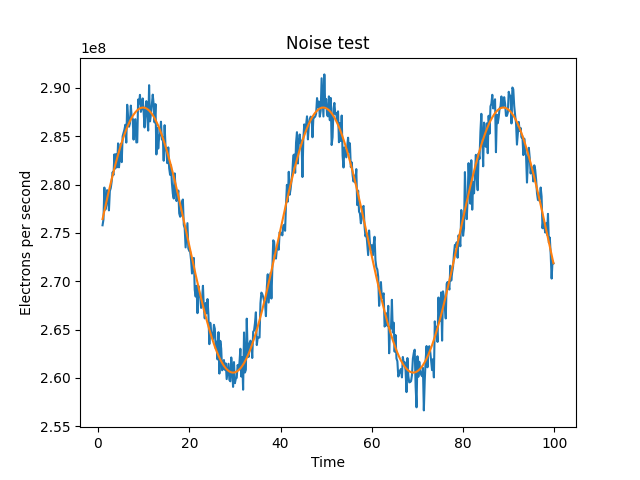

In [6]:
countsAvg = statistics.mean(photonCountRate)
countsStdev = statistics.stdev(photonCountRate)
    
elecSec = [i*countsAvg/gain for i in sinwave] #Currently transit is a seperate array, will likely change later when working on 2D data
mean_noise = 0
noise_calc = np.random.normal(mean_noise, np.sqrt(countsStdev)*200, len(elecSec))

noise = elecSec + noise_calc


fig = plt.figure()
plt.title('Noise test')
plt.plot(time, noise)
plt.plot(time,elecSec)
plt.xlabel('Time')
plt.ylabel('Electrons per second')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.show()